# Full Feature Selection Pipeline untuk Satu Domain Dataset

Notebook ini mencakup:
- Load dataset
- Preprocessing
- 6 Metode Feature Selection
- 3 Model klasifikasi
- Evaluasi metrik lengkap: F1, akurasi, waktu, memori, jumlah fitur, Jaccard, Kuncheva
- Visualisasi: heatmap dan ranking
- Validasi statistik: Friedman dan Nemenyi

**Note**: Jalankan ini untuk satu dataset/domain dalam satu waktu. Dataset harus disimpan sebagai `dataset.csv` dan memiliki kolom `target`.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
from memory_profiler import memory_usage
from joblib import parallel_backend

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2,
    RFE, SelectFromModel
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from boruta import BorutaPy
from sklearn.metrics import f1_score, accuracy_score
from sklearn.base import clone

# --- PARAMETER OPTIMASI ---
TOP_K           = 10     # fitur terpilih
SUB_RATIO       = 0.2    # 20% data untuk FS high-dim
RFE_STEP        = 50     # hapus 50 fitur per iterasi RFE
PCA_COMP        = 200    # komponen PCA
VAR_THRESH      = 0.01   # ambang VarianceThreshold
SUB_RATIO_FILTER = 0.1   # 10% data untuk filter FS di high-dim

Import semua library yang dibutuhkan untuk preprocessing, evaluasi, feature selection, dan statistik.

In [2]:
# Cell 3 – Load & Preprocess Data
csv_file = "citra_mnist.csv"   # ganti per domain
df = pd.read_csv(csv_file)
y  = df["target"]
X  = df.drop(columns=["target"], errors="ignore").select_dtypes(include=[np.number])

# 1) MinMax scaling untuk filter methods
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig   = X_scaled.copy()

# 2) Pra-reduksi untuk wrapper/embedded
if X_scaled.shape[1] > 300:
    pca   = PCA(n_components=PCA_COMP, random_state=42)
    X_red = pca.fit_transform(X_scaled)
    vt    = VarianceThreshold(threshold=VAR_THRESH)
    X_red = vt.fit_transform(X_red)
else:
    X_red = X_scaled

print(f"{csv_file}: orig_dim={X_orig.shape[1]}, red_dim={X_red.shape[1]}")

citra_mnist.csv: orig_dim=784, red_dim=200


Load dataset dari file `dataset.csv` dan lakukan standarisasi fitur numerik.

In [3]:
# Cell 5 – Run Eksperimen FS × Model (Chi2, RFE, LASSO only; models: LR & RF)
results = []

# stability metrics
def jaccard(a, b):
    return len(set(a) & set(b)) / len(set(a) | set(b))

def kun(a, b, n):
    k, r = len(a), len(set(a) & set(b))
    return (r * n - k * k) / (k * (n - k) + 1e-9)

# Define FS methods (only Chi2, RFE, LASSO)
fs_methods = {
    "Chi2" : SelectKBest(chi2, k=TOP_K),
    # "MutualInfo": SelectKBest(mutual_info_classif, k=TOP_K),
    "RFE"  : RFE(LogisticRegression(solver="liblinear"),
                 n_features_to_select=TOP_K, step=RFE_STEP),
    "LASSO": SelectFromModel(
                 LogisticRegression(penalty='l1', solver='liblinear'),
                 max_features=TOP_K)
}

# Define models (only Logistic Regression & Random Forest)
models = {
    "LogReg": LogisticRegression(solver="liblinear"),
    "RF"    : RandomForestClassifier(random_state=42)
    # "XGB": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Definisikan 6 metode Feature Selection dan 3 model klasifikasi yang akan digunakan.

In [4]:
for fs_name, fs in fs_methods.items():
    # skip logic not needed since only low-dim relevant here
    # subsample data untuk FS
    if X_red.shape[1] > 300:
        X_fs_red, _, y_fs_red, _ = train_test_split(
            X_red, y, train_size=SUB_RATIO, stratify=y, random_state=42
        )
        X_fs_orig, _, y_fs_orig, _ = train_test_split(
            X_orig, y, train_size=SUB_RATIO_FILTER, stratify=y, random_state=42
        )
    else:
        X_fs_red, y_fs_red   = X_red, y
        X_fs_orig, y_fs_orig = X_orig, y

    for mdl_name, mdl in models.items():
        print(f"[RUN] FS={fs_name}, Model={mdl_name}")
        f1s, accs, times, mems, feats, jacs, kuns = ([] for _ in range(7))
        prev_idx = None

        with parallel_backend('loky', n_jobs=2):
            for tr, te in skf.split(X_red, y):
                Xtr_red, Xte_red   = X_red[tr],   X_red[te]
                Xtr_orig, Xte_orig = X_orig[tr], X_orig[te]
                ytr, yte           = y.iloc[tr],  y.iloc[te]

                def apply_fs():
                    if fs_name == "Chi2":
                        fs.fit(X_fs_orig, y_fs_orig)
                        return np.where(fs.get_support())[0]
                    else:  # RFE or LASSO on reduced space
                        fs.fit(X_fs_red, y_fs_red)
                        return np.where(fs.get_support())[0]

                t0  = time.time()
                mem = memory_usage((apply_fs,), max_iterations=1)
                idx = apply_fs()
                dt  = time.time() - t0

                # pilih ruang fitur sesuai metode
                if fs_name == "Chi2":
                    Xtr, Xte = Xtr_orig[:, idx], Xte_orig[:, idx]
                else:
                    Xtr, Xte = Xtr_red[:, idx],   Xte_red[:, idx]

                clf = clone(mdl).fit(Xtr, ytr)
                yp  = clf.predict(Xte)

                # simpan metrik
                f1s.append(f1_score(yte, yp, average="macro"))
                accs.append(accuracy_score(yte, yp))
                times.append(dt)
                mems.append(max(mem))
                feats.append(len(idx))
                if prev_idx is not None:
                    jacs.append(jaccard(prev_idx, idx))
                    kuns.append(kun(prev_idx, idx, X_red.shape[1]))
                prev_idx = idx

        results.append({
            "FS_Method":    fs_name,
            "Model":        mdl_name,
            "F1_mean":      np.mean(f1s),
            "Acc_mean":     np.mean(accs),
            "Time_sec":     np.mean(times),
            "Memory_MB":    np.mean(mems),
            "Num_Features": np.mean(feats),
            "Jaccard":      np.mean(jacs) if jacs else None,
            "Kuncheva":     np.mean(kuns) if kuns else None
        })

# Konversi ke DataFrame & Simpan
results_df = pd.DataFrame(results)
results_df.to_csv("fs_result_one_domain2.csv", index=False)
results_df

[RUN] FS=Chi2, Model=LogReg
[RUN] FS=Chi2, Model=RF
[RUN] FS=RFE, Model=LogReg
[RUN] FS=RFE, Model=RF
[RUN] FS=LASSO, Model=LogReg
[RUN] FS=LASSO, Model=RF


,FS_Method,Model,F1_mean,Acc_mean,Time_sec,Memory_MB,Num_Features,Jaccard,Kuncheva
0,Chi2,LogReg,0.338699,0.389529,1.989081,1428.178385,10.0,1.0,1.0
1,Chi2,RF,0.396312,0.423471,2.599079,1531.161458,10.0,1.0,1.0
2,RFE,LogReg,0.722102,0.731900,548.377162,1685.796875,10.0,1.0,1.0
3,RFE,RF,0.843857,0.846714,433.734963,1644.050781,10.0,1.0,1.0
4,LASSO,LogReg,0.681126,0.693886,269.781052,1698.601562,10.0,1.0,1.0
5,LASSO,RF,0.809419,0.813757,268.990290,1769.934896,10.0,1.0,1.0


Lakukan evaluasi FS + klasifikasi. Simpan hasil ke CSV dan tampilkan dataframe hasil.

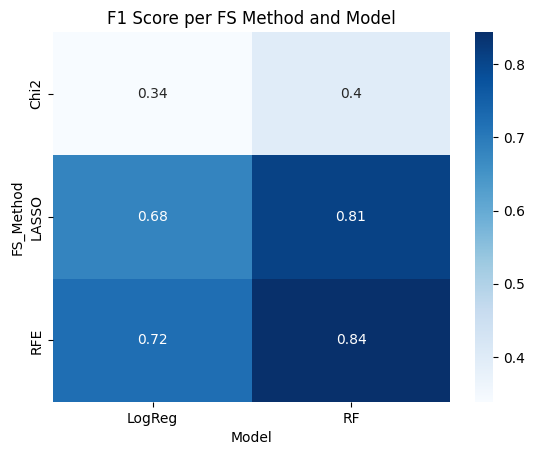

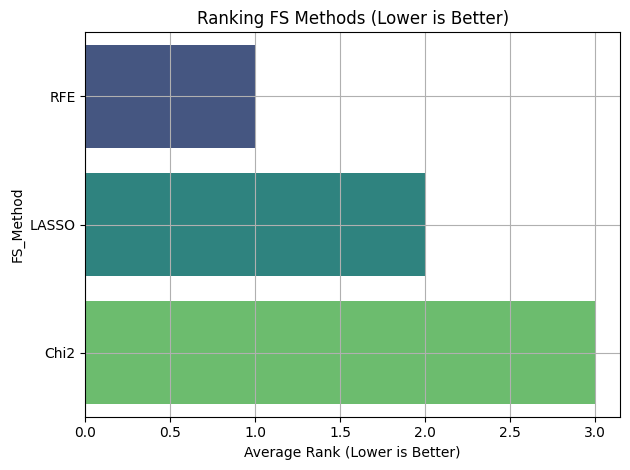

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap F1
pivot = results_df.pivot(index="FS_Method", columns="Model", values="F1_mean")
sns.heatmap(pivot, annot=True, cmap="Blues")
plt.title("F1 Score per FS Method and Model")
plt.show()

# Ranking
ranks = pivot.rank(ascending=False, axis=0)
avg_ranks = ranks.mean(axis=1).sort_values()

sns.barplot(x=avg_ranks.values, y=avg_ranks.index, palette="viridis")
plt.xlabel("Average Rank (Lower is Better)")
plt.title("Ranking FS Methods (Lower is Better)")
plt.grid(True)
plt.tight_layout()
plt.show()
